In [23]:
import numpy as np
import os
import csv
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import multiprocessing as mp
from oucorr import calcCorr
import itertools
import glob


SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 350107321 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['Solarize_Light2', '_classic_test_patch', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn', 'seaborn-bright', 'seaborn-colorblind', 'seaborn-dark', 'seaborn-dark-palette', 'seaborn-darkgrid', 'seaborn-deep', 'seaborn-muted', 'seaborn-notebook', 'seaborn-paper', 'seaborn-pastel', 'seaborn-poster', 'seaborn-talk', 'seaborn-ticks', 'seaborn-white', 'seaborn-whitegrid', 'tableau-colorblind10']


In [2]:
roi_time_series = pd.read_csv("sub-021_ses-bhb_task-rest_run-1.csv",header=None, index_col=False)

    # Convert into numpy array
roi_time_series = np.array(roi_time_series)
roi_time_series.shape

(720, 498)

In [3]:
# 720 = 24x30 so splitting it up into chuncks of 30 is a good idea
WINDOW_LENGTH = 30
REGIONS = 498
num = int((roi_time_series.shape[0] - 1 - \
               (roi_time_series.shape[0] - 1) % WINDOW_LENGTH) /
              WINDOW_LENGTH)
indicies = np.linspace(WINDOW_LENGTH, num*WINDOW_LENGTH, num).astype(int)

windows = np.array(np.split(roi_time_series, indicies, axis=0))

In [4]:
windows.shape

(24, 30, 498)

In [13]:
# normalize all datasets (mean=0 and std=1)
windows_mean = np.mean(windows,axis=1)
windows_std = np.std(windows,axis=1)
print(windows_mean.shape)
windows_norm = (windows-windows_mean[:,np.newaxis,:])/windows_std[:,np.newaxis,:]
print(windows_norm.shape)

(24, 498)
(24, 30, 498)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [14]:
C,dC,B1 = calcCorr(windows_norm,WINDOW_LENGTH,REGIONS)

/Users/hstrey/Documents/programming/fMRI-analysis/oucorr.py:29: RuntimeWarning: invalid value encountered in true_divide
  return ((3.0 * c / a) - ((b ** 2.0) / (a ** 2.0))) / 3.0
/Users/hstrey/Documents/programming/fMRI-analysis/oucorr.py:34: RuntimeWarning: invalid value encountered in true_divide
  return (((2.0 * (b ** 3.0)) / (a ** 3.0)) - ((9.0 * b * c) / (a **2.0)) + (27.0 * d / a)) /27.0
/Users/hstrey/Documents/programming/fMRI-analysis/oucorr.py:20: RuntimeWarning: invalid value encountered in true_divide
  P = (b / (3.0 * a)) * -1                # Helper Temporary Variable
/Users/hstrey/Documents/programming/fMRI-analysis/oucorr.py:22: RuntimeWarning: invalid value encountered in true_divide
  x1 = 2 * j * np.cos(k / 3.0) - (b / (3.0 * a))


In [15]:
C[0]

array([[  1.        ,  -0.81850286,   2.18687664, ...,  19.67654205,
          2.94869734,   0.42265072],
       [ -0.81850286,   1.        , -18.40198314, ...,  -0.85490067,
         -2.85389159, -13.78801985],
       [  2.18687664, -18.40198314,   1.        , ...,   4.55847282,
         12.92235383,   6.06002157],
       ...,
       [ 19.67654205,  -0.85490067,   4.55847282, ...,   1.        ,
          7.75735911,   0.2816618 ],
       [  2.94869734,  -2.85389159,  12.92235383, ...,   7.75735911,
          1.        ,   1.75110629],
       [  0.42265072, -13.78801985,   6.06002157, ...,   0.2816618 ,
          1.75110629,   1.        ]])

In [16]:
dC[0]

array([[ 0.        ,  2.40706077,  2.76683692, ..., 16.73764383,
         2.77967528,  1.76654009],
       [ 2.40706077,  0.        , 21.73514431, ...,  2.92369453,
         4.42395766, 15.02575548],
       [ 2.76683692, 21.73514431,  0.        , ...,  5.82733589,
        11.61806794,  9.20679021],
       ...,
       [16.73764383,  2.92369453,  5.82733589, ...,  0.        ,
         5.73547203,  1.8216444 ],
       [ 2.77967528,  4.42395766, 11.61806794, ...,  5.73547203,
         0.        ,  3.34907263],
       [ 1.76654009, 15.02575548,  9.20679021, ...,  1.8216444 ,
         3.34907263,  0.        ]])

In [17]:
B1[0]

array([[0.96887999, 0.97401917, 0.95299163, ..., 0.97423557, 0.95949061,
        0.93450989],
       [0.97401917, 0.93724747, 0.90912056, ..., 0.98774666, 0.92672538,
        0.91273055],
       [0.95299163, 0.90912056, 0.93460009, ..., 0.9561148 , 0.92993456,
        0.92684942],
       ...,
       [0.97423557, 0.98774666, 0.9561148 , ..., 0.97554752, 0.95988081,
        0.94105274],
       [0.95949061, 0.92672538, 0.92993456, ..., 0.95988081, 0.92530009,
        0.91887201],
       [0.93450989, 0.91273055, 0.92684942, ..., 0.94105274, 0.91887201,
        0.92377883]])

In [18]:
corrlength = len(C)
ids = np.arange(498)
subnet = np.array(list(itertools.product(ids, ids))).T
subnet_norm = np.sqrt(len(subnet.T))
print(subnet_norm)

498.0


In [19]:
instabilities_all = []
for tau in range(1,corrlength):
    diffs = np.array([C[i]-C[i+tau] for i in range(corrlength - tau)])
    inst = np.linalg.norm(diffs[:,subnet[0],subnet[1]], axis=1)/np.sqrt(subnet_norm*(subnet_norm-1))
    instabilities_all.append(inst)


In [20]:
instabilities_all

[array([15.89692192, 18.31147048, 16.21536209, 13.87414261, 13.23023058,
        19.036197  , 21.97453552, 19.01449643, 19.64616673, 21.0145016 ,
        19.98899673, 19.32936197, 15.33535452, 13.89599984, 18.12310192,
        18.46259801, 14.29952612, 13.77344027, 12.4683108 , 14.71012148,
        19.6731465 , 18.98653502, 17.99361885]),
 array([16.31525007, 18.02432047, 15.49917219, 16.36253929, 17.73596939,
        19.24034648, 21.05171781, 21.57978744, 19.91584291, 23.21117888,
        18.455486  , 19.84293149, 13.96141112, 19.16578125, 13.102042  ,
        20.068811  , 12.81558973, 14.91547491, 14.38592637, 18.66067709,
        18.00059924, 19.75104036]),
 array([14.94987903, 15.94755243, 17.52510377, 19.65569758, 17.5595672 ,
        17.88927821, 22.46478304, 20.98504492, 21.29083743, 19.95981077,
        18.57477979, 18.43456631, 19.41421986, 14.67640257, 14.16339719,
        18.48356164, 13.75071792, 16.47491092, 18.09638542, 16.81276483,
        17.73652405]),
 array([12.41350

In [21]:
inst_avg = [np.mean(inst) for inst in instabilities_all]
inst_std = [np.std(inst) for inst in instabilities_all]

<ErrorbarContainer object of 3 artists>

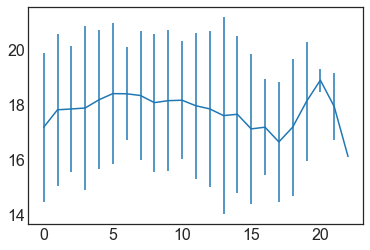

In [22]:
plt.errorbar(np.arange(23),y=inst_avg,yerr=inst_std)